In [12]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

In [5]:
# Read in text data
data = np.loadtxt('data/txtdata.csv', )
data

array([13., 24.,  8., 24.,  7., 35., 14., 11., 15., 11., 22., 22., 11.,
       57., 11., 19., 29.,  6., 19., 12., 22., 12., 18., 72., 32.,  9.,
        7., 13., 19., 23., 27., 20.,  6., 17., 13., 10., 14.,  6., 16.,
       15.,  7.,  2., 15., 15., 19., 70., 49.,  7., 53., 22., 21., 31.,
       19., 11., 18., 20., 12., 35., 17., 23., 17.,  4.,  2., 31., 30.,
       13., 27.,  0., 39., 37.,  5., 14., 13., 22.])

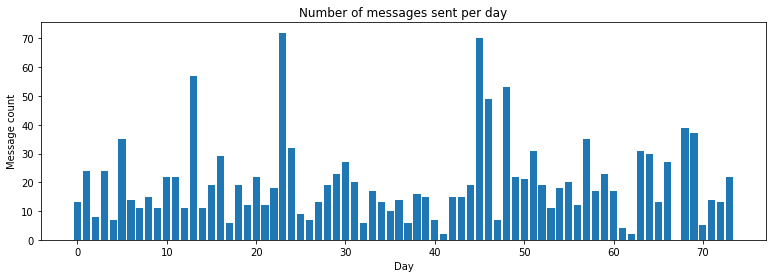

In [16]:
# Plot data
figsize(13, 4)
plt.bar(np.arange(len(data)), data)
plt.title('Number of messages sent per day')
plt.ylabel('Message count')
plt.xlabel('Day')
plt.show()

From the above figure there seems to be a change in the texting behavior around day 40-45. To determine which day the texting behavior changed we need to build a model.

In [55]:
# Define the models parameters
with pm.Model() as model:
    
    # Our initial guess on parameter alpha
    # We can use either declaration of alpha and the model will produce similar results
    alpha = pm.Uniform('alpha', lower=0, upper=1)
#     alpha = 1/len(data)
    
    # The message count data can be modeled using a Poisson distribution 
    l1 = pm.Exponential('lambda_1', alpha)
    l2 = pm.Exponential('lambda_2', alpha)
    
    tau = pm.DiscreteUniform('tau', lower=0, upper=len(data)-1)

In [57]:
with model:
    idx = np.arange(len(data)) 
    lambda_func = pm.math.switch(tau > idx, l1, l2)

tau


In [58]:
with model:
    observation = pm.Poisson("obs", lambda_func, observed=data)

In [59]:
# Sample posterior from our model
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
>Metropolis: [alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 30000/30000 [00:20<00:00, 1473.05draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [60]:
# Posterior samples
l1_samples = trace['lambda_1']
l2_samples = trace['lambda_2']
tau_samples = trace['tau']

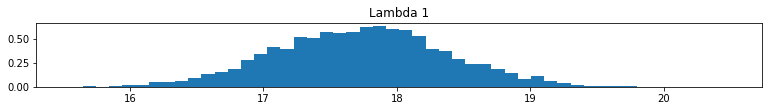

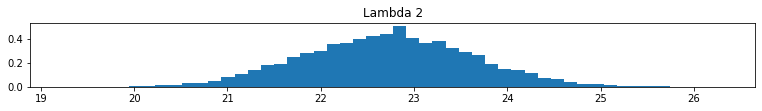

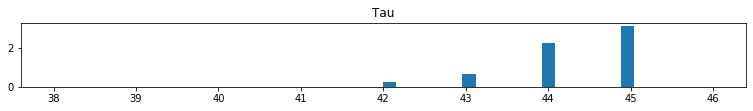

In [61]:
# Plot the posterior distributions
ax = plt.subplot(311)
plt.hist(l1_samples, bins=50, density=True)
plt.title('Lambda 1')
plt.show()

ax = plt.subplot(312)
plt.hist(l2_samples, bins=50, density=True)
plt.title('Lambda 2')
plt.show()

ax = plt.subplot(313)
plt.hist(tau_samples, bins=50, density=True)
plt.title('Tau')
plt.show()

We can see from the above `tau` posterior distribution that, day 45 is most likely the day the texting behavior changed.

In [62]:
np.sum(l1_samples < l2_samples)/len(l1_samples)

1.0

We can be confident that there is no overalp between the two lambda posterior distributions.  